## Dynamic Time Warping

This demo illustrates how to use the [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) implementation of this library.

Dynamic time warping is an algorithm to compare time series, accounting for differences in frequency. As a simple example, let's compare a regular sine wave to a sine wave with increasing frequency.

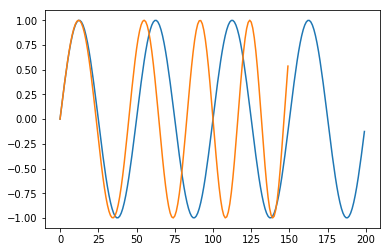

In [7]:
import numpy as np
t = np.arange(200)
initial_freq = 2 * np.pi / 50
x = np.sin(t * initial_freq)
t = np.arange(150)
final_freq   = 4 * np.pi / 50
y = np.sin(t * initial_freq + 0.5 * t ** 2 * (final_freq - initial_freq) / 200)

import matplotlib.pyplot as plt
plt.plot(x)
plt.plot(y)
plt.show()

Note how both signals vary in length and frequency, but cover the same number of periods. Accordingly, we expect the dynamic time warping to be low, which we can easily check.

In [2]:
import edist.dtw as dtw
d = dtw.dtw_numeric(x, y)
print('The dynamic time warping distance of the signals is %g; This corresponds to %g%% of the maximum distance' % (d, 100 * d / (200 * 2)))

The dynamic time warping distance of the signals is 6.63549; This corresponds to 1.65887% of the maximum distance


Dynamic time warping is a flexible method that does not only work with univariate time series but also other kinds of signals. For example, assume we wish to compare strings.

In [3]:
x = 'abac'
y = 'aaabaaccc'
print('The dynamic time warping distance between the strings %s and %s is %g' % (x, y, dtw.dtw_string(x, y)))

The dynamic time warping distance between the strings abac and aaabaaccc is 0


Or let's say we wish to compare a multivariate time series of three angles (yaw, pitch, and roll) using the difference between cosines as distance measure between frames.

In [4]:
x = np.array([[0., 10., 30., 60., 170., 260., 220., 200.], [0., -20., -40., -35., -37., -40., -40., -40.], [0., -2., 2., 10., 20., 20., 10., 0.]]).T
y = np.zeros((10, 3))
# define the local distance function delta, i.e. the distance between cosines
def delta(x, y):
    return np.sum(np.abs(np.cos(x * 2 * np.pi / 360.) - np.cos(y * 2 * np.pi / 360.)))
# then compute the custom dynamic time warping distance corresponding to it
print('The dynamic time warping distance between maneuver x and stillness is %g' % dtw.dtw(x, y, delta) )
print('The dynamic time warping distance between maneuver x and itself shifted by 360 degrees is %g' % dtw.dtw(x, x + 360, delta) )

The dynamic time warping distance between maneuver x and stillness is 9.04392
The dynamic time warping distance between maneuver x and itself shifted by 360 degrees is 3.63598e-15


Note that dynamic time warping has quadratic complexity, or more precisely $\mathcal{O}(m \cdot n)$, where $m$ and $n$ are the length of x and y, respectively. This may become prohibitive for very large sequences. Fortunately, though, due to the implementation being in [cython](https://cython.org/), it holds up to quite long sequences. Consider the following comparison with an implementation in pure python.

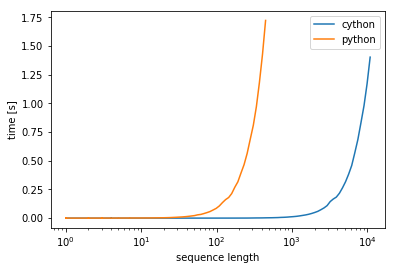

on average, cython is faster by a factor of 424.979
for higher lengths, cython is faster by a factor of 749.308


In [5]:
def dtw_pure_python(x, y):
    # First, compute all pairwise replacements
    Delta = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            Delta[i, j] = np.abs(x[i] - y[j])
    # Then, compute the dynamic time warping
    # distance
    D = np.zeros((len(x), len(y)))
    # initialize first entry
    D[0, 0] = Delta[0, 0]
    # initialize first column
    for i in range(len(x)-1):
        D[i+1,0] = Delta[i,0] + D[i,0]
    # initialize first row
    for j in range(len(y)-1):
        D[0,j+1] = Delta[0,j] + D[0,j]
    # compute the remainder of the table
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            D[i+1,j+1] = Delta[i,j] + np.min([D[i,j], D[i+1,j], D[i,j+1]])
    return D[len(x) - 1,len(y) - 1]

import time

lengths = np.exp(np.linspace(0, 9.3, 100)).astype(np.int)
times_cython = []
times_python = []

for l in lengths:
    # create two sequences of length l with random content
    x = np.random.rand(l)
    y = np.random.rand(l)
    # test our implementation
    start = time.time()
    dtw.dtw_numeric(x, y)
    times_cython.append(time.time() - start)
    # test the pure python implementation (until the computation time exceeds 0.5 second)
    if(times_python and times_python[-1] > 1.5):
        continue
    start = time.time()
    dtw_pure_python(x, y)
    times_python.append(time.time() - start)

plt.semilogx(lengths, times_cython)
plt.semilogx(lengths[:len(times_python)], times_python)
plt.legend(['cython', 'python'])
plt.xlabel('sequence length')
plt.ylabel('time [s]')
plt.show()

print('on average, cython is faster by a factor of %g' % np.mean(np.array(times_python) / np.array(times_cython[:len(times_python)])))
print('for higher lengths, cython is faster by a factor of %g' % np.mean(np.array(times_python[30:]) / np.array(times_cython[30:len(times_python)])))

Another challenge is the computation of pairwise distances for large data sets of sequences. To support this, we make use of parallelization. Consider the following comparison between parallel processing and a naive computation in a nested loop. Note how iterative computation is faster for small data sets! This is also true for relatively short sequences (up to ~200 elements).

computing dataset size 10
computing dataset size 20
computing dataset size 30
computing dataset size 40
computing dataset size 50
computing dataset size 60
computing dataset size 70
computing dataset size 80
computing dataset size 90


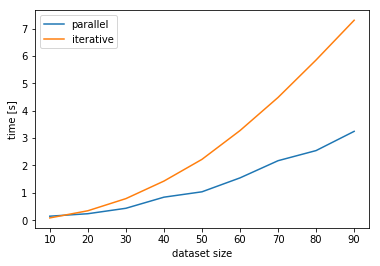

on average, parallel processing is faster by a factor of 1.82361


In [6]:
import edist.multiprocess as mp

dataset_sizes = np.arange(10, 100, 10)

times_parallel  = []
times_iterative = []
for m in dataset_sizes:
    print('computing dataset size %d' % m)
    # create a dataset of m sequences, all of length 500
    X = np.random.rand(m, 500)
    # test our implementation
    start = time.time()
    D = mp.pairwise_distances_symmetric(X, dtw.dtw_numeric)
    times_parallel.append(time.time() - start)
    # test iterative implementation
    start = time.time()
    for i in range(m):
        for j in range(i+1, m):
            dtw.dtw_numeric(X[i], X[j])
    times_iterative.append(time.time() - start)

plt.plot(dataset_sizes, times_parallel)
plt.plot(dataset_sizes, times_iterative)
plt.legend(['parallel', 'iterative'])
plt.xlabel('dataset size')
plt.ylabel('time [s]')
plt.show()

print('on average, parallel processing is faster by a factor of %g' % np.mean(np.array(times_iterative) / np.array(times_parallel)))